In [2]:
# SEISMON Notebook: Train a GPR model for ground motion prediction from earthquakes for use at LIGO Sites

# AUTHOR: Nikhil Mukund Menon (MIT Kavli - LIGO Laboratory)
# LAST EDITED: 04-04-2023
# PYTHON VERSION: Python 3.8.12


import GPy
import numpy as np
import pandas as pd
import os
import pickle
import obspy
from obspy.geodetics.base import gps2dist_azimuth as gps2dist_azimuth
from permetrics.regression import RegressionMetric

# visualize
import matplotlib.pyplot as plt

# specify IFO {'LLO','LHO','BOTH'}
# NOTE: BOTH not implemented  yet
ifo = 'LLO'

# code_path
code_path = './'

# Calculate percentage captured within factor of 
Fac=2

# Specify myKernel
myKernel = 'RatQuad' #  'RatQuad','Matern52','Matern32','RBF','ExpQuad'

# Generate some random data for the regression
np.random.seed(0)


In [3]:
result_folder  = os.path.join(code_path,'results',ifo,myKernel)
if not os.path.exists(result_folder):
   os.makedirs(result_folder)

In [4]:
# define utility functions

# rescale EQ params
def reScaleParams(lat,lon,mag,depth,dist):
    eps = np.finfo(float).eps
    # apply transform to params
    # NOTE: Make sure to apply the correct inverse transform in compareResults
    nlat = 5.0+(lat/50)
    nlon = 5.0+(lon/100)
    ndepth=10.0/np.log10(abs(depth)+eps)
    ndist=10.0/np.log10(abs(dist)+eps)
    nmag = mag
    #nrfAmp = 3+np.log10(abs(rfAmp)+eps);
    return nlat,nlon,nmag,ndepth,ndist

def undoReScaleParams(nlat,nlon,nmag,ndepth,ndist):
    eps = np.finfo(float).eps
    # apply transform to params
    # NOTE: Make sure to apply the correct inverse transform in compareResults
    lat = 50*(nlat-5.0)
    lon = 100*(nlon-5.0)
    depth=10**(10.0/(abs(ndepth)+eps))
    dist=10**(10.0/(abs(ndist)+eps))
    mag = nmag
    return lat,lon,mag,depth,dist



# make predictions in um/s using the trained GPR model
def gprPredict(load_model,model_fullname,model,ifo_name,lat,lon,mag,depth):   

    if load_model == 1:
        # load model
        # load model using pickle
        # print('loading model: '+model_fullname)
        model = pickle.load(open(model_fullname,"rb"))
    else:
        print('using preloaded model')

    lat = np.array([lat]).flatten()
    lon = np.array([lon]).flatten()
    mag = np.array([mag]).flatten()
    depth = np.array([depth]).flatten()
    # get ifo coordinates
    if ifo_name.lower()=='llo' or ifo_name.lower() =='l1' or ifo_name.lower()=='livingston' :
        ifo_lat = 30.5630
        ifo_lon = -90.7742
    elif ifo_name.lower()=='lho' or ifo_name.lower() =='h1' or ifo_name.lower()=='hanford' :
        ifo_lat = 46.2353
        ifo_lon = -119.2704
    # calculate distance
    dist=np.array([])
    # calculate distance
    for ijk in np.arange(np.size(lat)):
        #dist in meters
        tempDist = gps2dist_azimuth(ifo_lat, ifo_lon, lat[ijk], lon[ijk])[0]
        # dist in degrees (consistent with MATLAB distace() func output )
        tempDistAngle = (tempDist/1e3)*(180/np.pi)*(1.0/6371)
        dist = np.append(dist, tempDistAngle)            
    # apply rescaling
    nlat,nlon,nmag,ndepth,ndist = reScaleParams(lat,lon,mag,depth,dist)
    X = np.array([nlat,nlon,nmag,ndepth,ndist]).transpose()
    #  standardize using model.X_mean & model.X_std
    X = (X - model.X_mean) / model.X_std
    # make predicts using the model with one sigma uncertainty
    mean_pred, var_pred = model.predict(X)
    std_pred = np.sqrt(var_pred)
    # Destandardize the model predictions
    Y_pred     = (model.Y_std*mean_pred) + model.Y_mean
    Y_pred_std = (model.Y_std*std_pred)  
    
    # rescale
    Y_pred      = 10**(Y_pred-3)
    Y_pred_std  = 10**(Y_pred_std)
    Y_pred = np.array(Y_pred).flatten()
    Y_pred_std = np.array(Y_pred_std).flatten()


    return Y_pred,Y_pred_std,model

# make predictions in um/s using the Analytical PowerLaw  model
def powerLawFit(ifo_name,lat,lon,mag,depth):   
    R_earth = 6371
    pi = np.pi
    lat = np.array([lat]).flatten()
    lon = np.array([lon]).flatten()
    mag = np.array([mag]).flatten()
    depth = np.array([depth]).flatten()
    
    # get ifo coordinates
    if ifo_name.lower()=='llo' or ifo_name.lower() =='l1' or ifo_name.lower()=='livingston' :
        ifo_lat = 30.5630
        ifo_lon = -90.7742
    elif ifo_name.lower()=='lho' or ifo_name.lower() =='h1' or ifo_name.lower()=='hanford' :
        ifo_lat = 46.2353
        ifo_lon = -119.2704
    dist = np.zeros(len(lat),)        
    Y_pred_powerLaw = np.zeros(len(lat),)
    Y_pred_powerLaw_std = np.zeros(len(lat),) + np.finfo(float).eps # powerLaw doesn't provide uncertainity

    for ijk in range(len(lat)):
        dist[ijk] = gps2dist_azimuth(ifo_lat,ifo_lon,lat[ijk],lon[ijk])[0]/1e3     
        #  updated one from Eyal [SEI LOG: 2104]
        if ifo_name.lower()=='llo' or ifo_name.lower() =='l1' or ifo_name.lower()=='livingston':
            Y_pred_powerLaw[ijk] = np.exp(2.25*mag[ijk] - 1.54*np.log(dist[ijk]/R_earth/pi) - 0.22*np.log(depth[ijk]/R_earth) - 16.29)
        #TO-FIX: currently uses same formula for LHO/GEO/VIRGO    
        else:
            Y_pred_powerLaw[ijk] = np.exp(2.34*mag[ijk] - 2.72*np.log(dist[ijk]/R_earth/pi) - 0.28*np.log(depth[ijk]/R_earth) - 18.01)
        
    # return powerLaw result
    return Y_pred_powerLaw,Y_pred_powerLaw_std




def plot_prediction(Y_meas,Y_pred,Y_pred_std,
                    save_fig_and_metrics=0,
                    fig_name='temp.png',
                    fig_title='',
                    Fac=5,
                    plot_uncertainity=0,
                    save_location='./'):
    Y_meas = np.array(Y_meas)
    Y_meas = Y_meas.reshape((len(Y_meas),1))
    Y_pred = Y_pred.reshape((len(Y_pred),1))
    Y_pred_std = Y_pred_std.reshape((len(Y_pred_std),1))

    # sort Y [max to min] & get index
    idx = np.argsort(Y_meas,axis=0)
    # reverse index [max to min]
    #idx = np.flipud(idx)
    # sort
    Y_meas = Y_meas[idx,:].flatten(); 
    Y_pred = Y_pred[idx].flatten();  
    Y_pred_std = Y_pred_std[idx].flatten();    
    # Plot 
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    XVAL = np.arange(len(Y_meas)).flatten()
    # shhow factor of fac around Y_meas
    plt.fill_between(XVAL, Y_meas/Fac, Y_meas*Fac,
                   color='green', alpha=0.3, label="Factor of {}".format(Fac))    
    # Fill the one sigma uncertainty region
    if plot_uncertainity==1:
        plt.errorbar(XVAL,Y_meas,yerr=Y_pred_std,alpha=0.3,
                 color='grey',label="Prediction uncertainty",
                 errorevery=30)
    # Plot the prediction
    plt.plot(XVAL, Y_pred, 'k*', alpha=0.5,label="Prediction")
    # Plot measured values
    plt.scatter(XVAL, Y_meas,marker='o', alpha=0.9, label="Actual Output")    
    # Add a legend to the plot
    plt.legend(loc='lower left',fontsize=15)
    # log scale
    plt.yscale('log')
    # label axis
    plt.xlabel('Event ID',fontsize=20)
    plt.ylabel('Peak Amplitude [um/s]',fontsize=20)
    plt.title(fig_title,fontsize=20)
    plt.grid()
    # add captured percentage info
    Captured_pc = captured_percent(Y_meas,Y_pred,Fac)
    plt.annotate('Percentage captured\nwithin a factor of {}: {:0.2f}%'.format(Fac,Captured_pc),xy=(10,5e1,),fontsize=15)
    # display regression metrics as a table
    # Create a table and add it to the plot
    DF = get_metrics(Y_meas,Y_pred)
    table = ax.table(cellText=DF.values, colLabels=DF.columns, loc='center',bbox=[0.5, 0.05, 0.4, 0.3])
    # Modify table properties, such as font size and cell padding
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(0.2, 0.4)
    # save the plot
    if save_fig_and_metrics==1:
        plt.savefig(os.path.join(save_location,fig_name))
        DF['Captured_pc']=np.round(Captured_pc,2)
        DF.to_csv(os.path.join(save_location,fig_name.replace('.png','.txt')),index=False)
    # Show the plot
    plt.show()        


def scatter_plot_prediction(Y_meas,Y_pred,Y_pred_std,
                    save_fig_and_metrics=0,
                    fig_name='temp_scatter.png',
                    fig_title='',
                    Fac=5,
                    plot_uncertainity=0,
                    save_location='./'):
    #make scatter plot
    Y_meas = np.array(Y_meas)
    Y_meas = Y_meas.reshape((len(Y_meas),1))
    Y_pred = Y_pred.reshape((len(Y_pred),1))
    Y_pred_std = Y_pred_std.reshape((len(Y_pred_std),1))
    # sort Y [max to min] & get index
    idx = np.argsort(Y_meas,axis=0)
    # reverse index [max to min]
    #idx = np.flipud(idx)
    # sort
    Y_meas = Y_meas[idx,:].flatten(); 
    Y_pred = Y_pred[idx].flatten();  
    Y_pred_std = Y_pred_std[idx].flatten();  
    # PLOT
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.plot(Y_meas, Y_pred, 'o', c='blue', alpha=0.3, markeredgecolor='none',markersize=10)
    ax.set_aspect('equal')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid()
    ax.axis([5e-2,2e2,5e-2,2e2]);
    ax.set_ylabel('Prediction [um/s]',fontsize=20);
    ax.set_xlabel('Measurement [um/s]',fontsize=20);
    ax.set_title(fig_title,fontsize=20)
    """ax.plot(ax.get_xlim(), ax.get_xlim(),'--k')
    ax.plot(ax.get_xlim(), ax.get_xlim(),'--k')"""
    LIM = np.linspace(*ax.get_xlim())
    ax.plot(LIM, LIM,'--k')
    ax.plot(LIM, Fac*LIM,'--k')
    ax.plot(LIM, (1/Fac)*LIM,'--k')
    percentage_captured = captured_percent(Y_meas,Y_pred,Fac)
    #plt.text(2, 3e-2, 'percentage captured within a factor of {} : {:0.2f} %'.format(FAC,percentage_captured), fontsize=12)
    plt.text(1e-1,5e1, 'percentage captured within a factor of {} : {:0.2f} %'.format(Fac,percentage_captured), fontsize=15)
    # display regression metrics as a table
    # Create a table and add it to the plot
    DF = get_metrics(Y_meas,Y_pred)
    table = ax.table(cellText=DF.values, colLabels=DF.columns, loc='center',bbox=[0.5, 0.05, 0.4, 0.3])
    # Modify table properties, such as font size and cell padding
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(0.2, 0.4)
        
    # save the plot
    if save_fig_and_metrics==1:
        plt.savefig(os.path.join(save_location,fig_name))
    # Show the plot
    plt.show()        



def captured_percent(measurements,predictions,Fac):
    K = np.divide(predictions,measurements)
    L = predictions[K>1] <= Fac*measurements[K>1] 
    M = predictions[K<1] >= np.divide(measurements[K<1],Fac);
    Captured_pc = 100*np.divide((sum(L) + sum(M)),np.size(K));
    return Captured_pc
    
def get_metrics(Y_meas,Y_pred):
    evaluator = RegressionMetric(Y_meas, Y_pred, decimal=2)
    EVAL_METRICS= pd.DataFrame([[evaluator.R2(),
                            evaluator.RMSE(),
                            evaluator.SMAPE(),
                            evaluator.NRMSE()]],
                            columns=['R2','RMSE','SMAPE','NRMSE']
                            )
    print(EVAL_METRICS)
    return EVAL_METRICS

    

In [5]:
# load train & test data (copied from GEO-ana4 machine SEISMON folder)
# EQ variables are already normalized

# if single Detector
if ifo.lower() != 'both':
    NT_train=pd.read_csv('NT_train_'+ifo+'.csv')
    NT_test=pd.read_csv('NT_test_'+ifo+'.csv')
    X_train = NT_train.iloc[:,0:-1]
    Y_train = NT_train.iloc[:,5]
    X_test = NT_test.iloc[:,0:-1]
    Y_test = NT_test.iloc[:,5]

else:
    NT_train_LLO=pd.read_csv('NT_train_'+"LLO"+'.csv'); NT_train_LLO['ifo_id'] = np.ones((NT_train_LLO.shape[0],1),dtype=int)
    NT_test_LLO=pd.read_csv('NT_test_'+"LLO"+'.csv'); NT_test_LLO['ifo_id']    = np.ones((NT_test_LLO.shape[0],1),dtype=int)
    NT_train_LHO=pd.read_csv('NT_train_'+"LHO"+'.csv'); NT_train_LHO['ifo_id'] = np.ones((NT_train_LHO.shape[0],1),dtype=int) + int(1)
    NT_test_LHO=pd.read_csv('NT_test_'+"LHO"+'.csv'); NT_test_LHO['ifo_id']    = np.ones((NT_test_LHO.shape[0],1),dtype=int)  + int(1)
    NT_train =  NT_train_LLO.append(NT_train_LHO,ignore_index=1)
    NT_test =  NT_test_LLO.append(NT_test_LHO,ignore_index=1)
    X_train = pd.DataFrame(NT_train,columns=['nlat', 'nlon', 'nmag', 'ndepth', 'ndist', 'ifo_id'])
    Y_train = pd.DataFrame(NT_train,columns=['nrfAmp'])

X = np.array(X_train)
Y = np.array(Y_train)


In [6]:



# Standardize the input and output parameters
X_mean, X_std = np.mean(X, axis=0), np.std(X, axis=0)
Y_mean, Y_std = np.mean(Y, axis=0), np.std(Y, axis=0)
X = (X - X_mean) / X_std
Y = (Y - Y_mean) / Y_std


# sort Y [max to min] & get index
idx = np.argsort(Y,axis=0)
# reverse index [max to min]
idx = np.flipud(idx)

X = X[idx,:]
Y = Y[idx]

X_copy = X
Y_copy = Y


In [7]:
input_dim = int(X_mean.shape[0])

# Define the myKernel for the Gaussian process model
#baseline
if myKernel == 'RatQuad':
    myKernel = GPy.kern.RatQuad(input_dim=input_dim, ARD=True)
elif myKernel == 'Matern52':
    myKernel = GPy.kern.Matern52(input_dim=input_dim, ARD=True)
elif myKernel == 'RBF':
    myKernel = GPy.kern.RBF(input_dim=input_dim, ARD=True)    
elif myKernel == 'ExpQuad':
    myKernel = GPy.kern.ExpQuad(input_dim=input_dim, ARD=True)        




# Create the Gaussian process model
model = GPy.models.GPRegression(X, Y[:, None], kernel=myKernel )


# Optimize the hyperparameters of the model
#model.optimize() # initial
model.optimize('lbfgs', max_iters=200)



# Get the optimized hyperparameters
print("Optimized Hyperparameters:")
print("Variance: ", model.kern.variance)
print("Lengthscales: ", model.kern.lengthscale)





Optimized Hyperparameters:
Variance:    index  |  GP_regression.RatQuad.variance  |  constraints  |  priors
  [0]    |                      4.42449462  |      +ve      |        
Lengthscales:    index  |  GP_regression.RatQuad.lengthscale  |  constraints  |  priors
  [0]    |                         1.51667714  |      +ve      |        
  [1]    |                         8.91659932  |      +ve      |        
  [2]    |                         2.27051590  |      +ve      |        
  [3]    |                         3.70617274  |      +ve      |        
  [4]    |                         1.17517866  |      +ve      |        


In [8]:
# METHOD 2 : SAVE & LOAD

# include {input,output} mean & std info used for Standardization
model.X_mean = X_mean
model.X_std  = X_std
model.Y_mean = Y_mean
model.Y_std  = Y_std

# save model using pickle
model_name = "gpr_model_"+ifo+".dump"
models_path = result_folder
model_fullname = os.path.join(models_path,model_name)

# save model
with open(model_fullname, "wb") as f:
     pickle.dump(model, f)  

# load model using pickle
model = pickle.load(open(model_fullname,"rb"))
model     


GP_regression.,value,constraints,priors
RatQuad.variance,4.424494619871473,+ve,
RatQuad.lengthscale,"(5,)",+ve,
RatQuad.power,0.17756218375721577,+ve,
Gaussian_noise.variance,0.3356898773999948,+ve,


     R2   RMSE  SMAPE  NRMSE
0  0.54  13.57   0.26   0.99
     R2   RMSE  SMAPE  NRMSE
0  0.54  13.57   0.26   0.99


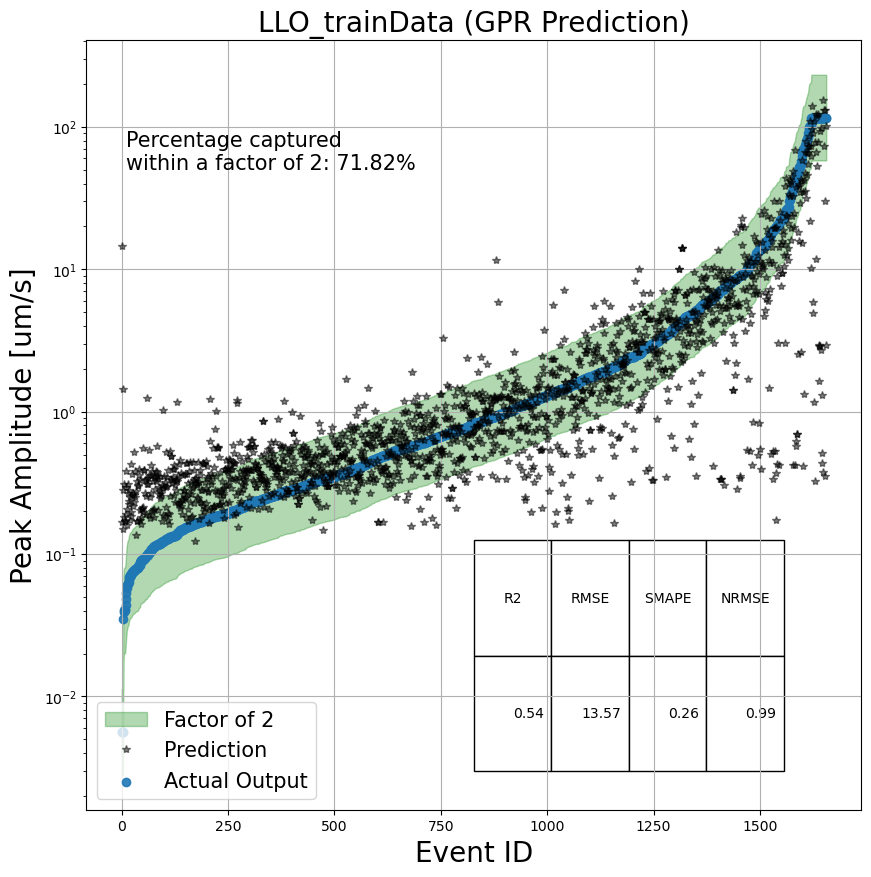

     R2   RMSE  SMAPE  NRMSE
0  0.54  13.57   0.26   0.99


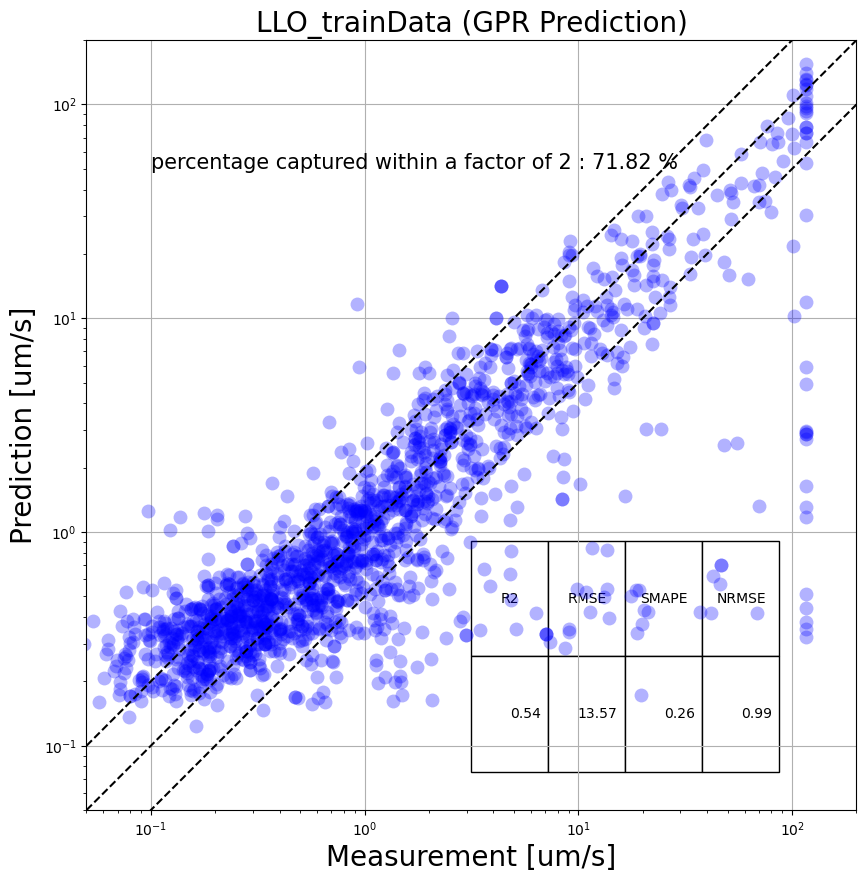

In [9]:

# make predictions on train Data using GPR 
# call via function
# LOOKS GOOD


ifo_name = ifo

# make predictions on train Data
XDATA  = X_train
YDATA  = Y_train; 
lat,lon,mag,depth,dist = undoReScaleParams(XDATA.nlat,XDATA.nlon,XDATA.nmag,XDATA.ndepth,XDATA.ndist)

Y_meas = np.array(10**(YDATA-3))

load_model=1
Y_pred,Y_pred_std,model = gprPredict(load_model,model_fullname,model,ifo_name,lat,lon,mag,depth)


# Show Regression Metrics
get_metrics(Y_meas,Y_pred)

plot_prediction(Y_meas,Y_pred,Y_pred_std,
                save_fig_and_metrics=1,
                fig_name='{}_trainData_GPR.png'.format(ifo),
                fig_title='{}_trainData (GPR Prediction)'.format(ifo),
                Fac=Fac,
                plot_uncertainity=0,
                save_location=result_folder
                )

scatter_plot_prediction(Y_meas,Y_pred,Y_pred_std,
                save_fig_and_metrics=1,
                fig_name='{}_trainData_GPR_scatter.png'.format(ifo),
                fig_title='{}_trainData (GPR Prediction)'.format(ifo),
                Fac=Fac,
                plot_uncertainity=0,
                save_location=result_folder
                )



     R2   RMSE  SMAPE  NRMSE
0  0.04  19.55   0.32   1.01
     R2   RMSE  SMAPE  NRMSE
0  0.04  19.55   0.32   1.01


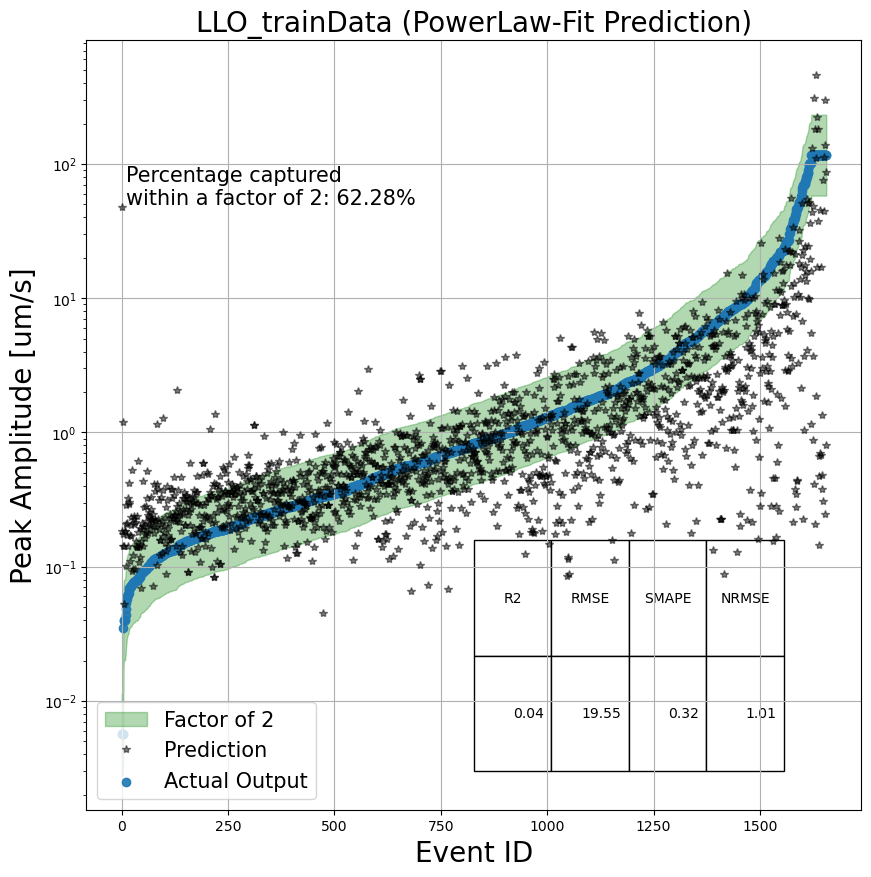

     R2   RMSE  SMAPE  NRMSE
0  0.04  19.55   0.32   1.01


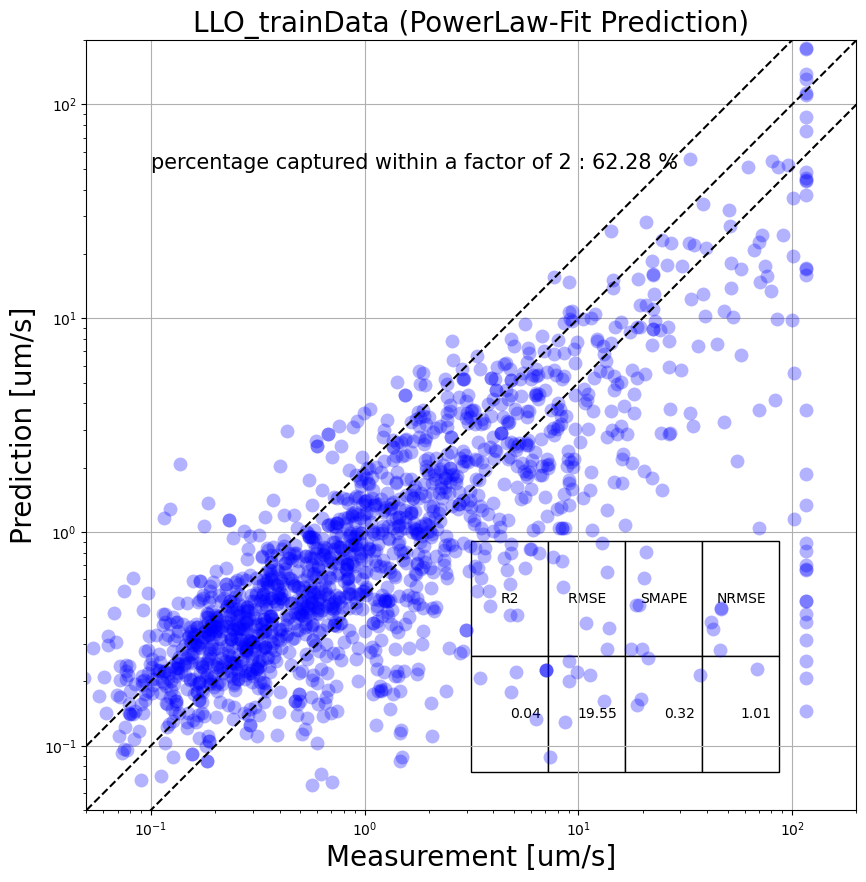

In [10]:
# make predictions on train Data using PowerLaw-Fit 
# call via function



ifo_name = ifo

# make predictions on train Data
XDATA  = X_train
YDATA  = Y_train; 


lat,lon,mag,depth,dist = undoReScaleParams(XDATA.nlat,XDATA.nlon,XDATA.nmag,XDATA.ndepth,XDATA.ndist)

Y_meas = np.array(10**(YDATA-3))


Y_pred,Y_pred_std = powerLawFit(ifo_name,lat,lon,mag,depth)

# Show Regression Metrics
get_metrics(Y_meas,Y_pred)

plot_prediction(Y_meas,Y_pred,Y_pred_std,
                save_fig_and_metrics=1,
                fig_name='{}_trainData_PowerLawFit.png'.format(ifo),
                fig_title='{}_trainData (PowerLaw-Fit Prediction)'.format(ifo),
                Fac=Fac,
                plot_uncertainity=0,
                save_location=result_folder
                )

scatter_plot_prediction(Y_meas,Y_pred,Y_pred_std,
                save_fig_and_metrics=1,
                fig_name='{}_trainData_PowerLawFit_scatter.png'.format(ifo),
                fig_title='{}_trainData (PowerLaw-Fit Prediction)'.format(ifo),
                Fac=Fac,
                plot_uncertainity=0,
                save_location=result_folder
                )



     R2   RMSE  SMAPE  NRMSE
0  0.43  15.82   0.29   1.35


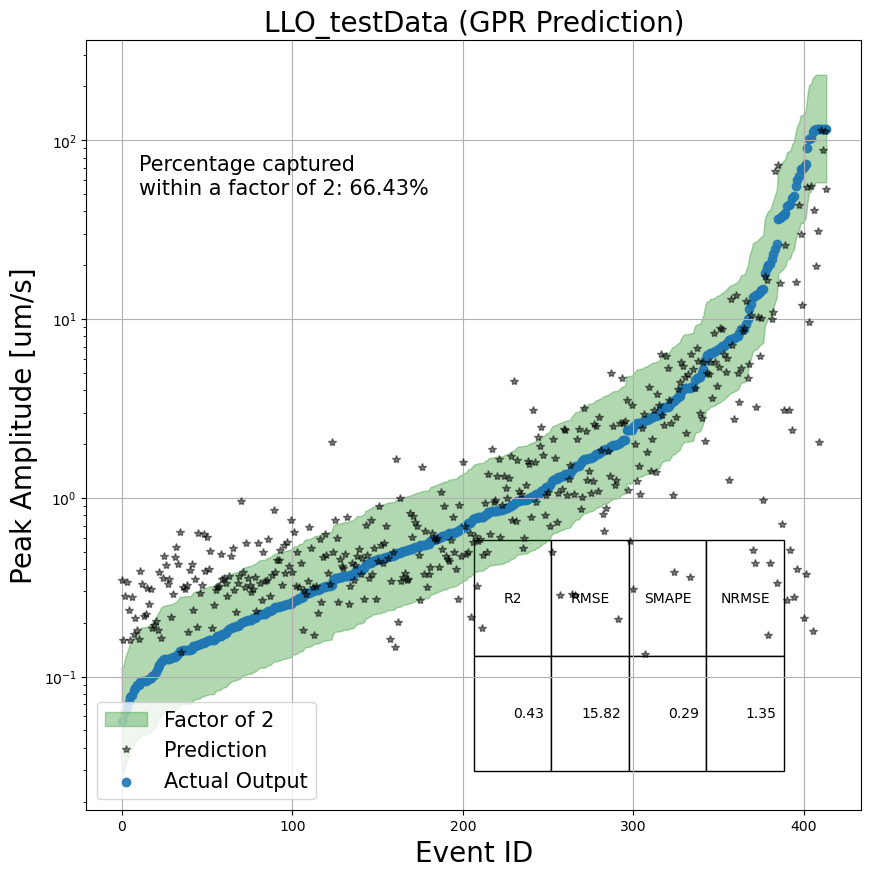

     R2   RMSE  SMAPE  NRMSE
0  0.43  15.82   0.29   1.35


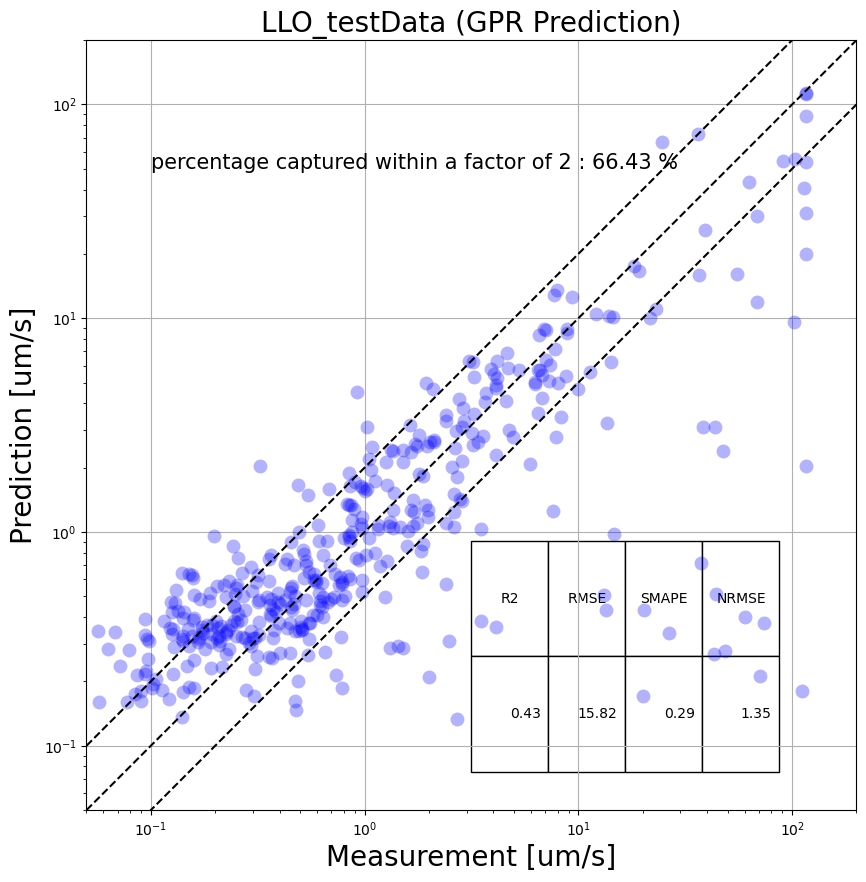

In [11]:
# make predictions on test Data using GPR
XDATA  = X_test
YDATA  = Y_test 
lat,lon,mag,depth,dist = undoReScaleParams(XDATA.nlat,XDATA.nlon,XDATA.nmag,XDATA.ndepth,XDATA.ndist)

Y_meas = np.array(10**(YDATA-3))



load_model=1
Y_pred,Y_pred_std,model= gprPredict(load_model,model_fullname,model,ifo_name,lat,lon,mag,depth)



plot_prediction(Y_meas,Y_pred,Y_pred_std,
                save_fig_and_metrics=1,
                fig_name='{}_testData.png'.format(ifo),
                fig_title='{}_testData (GPR Prediction)'.format(ifo),
                Fac=Fac,
                plot_uncertainity=0,
                save_location=result_folder
                )

scatter_plot_prediction(Y_meas,Y_pred,Y_pred_std,
                save_fig_and_metrics=1,
                fig_name='{}_testData_scatter.png'.format(ifo),
                fig_title='{}_testData (GPR Prediction)'.format(ifo),
                Fac=Fac,
                plot_uncertainity=0,
                save_location=result_folder
                )



     R2   RMSE  SMAPE  NRMSE
0 -4.86  50.81   0.33   0.93


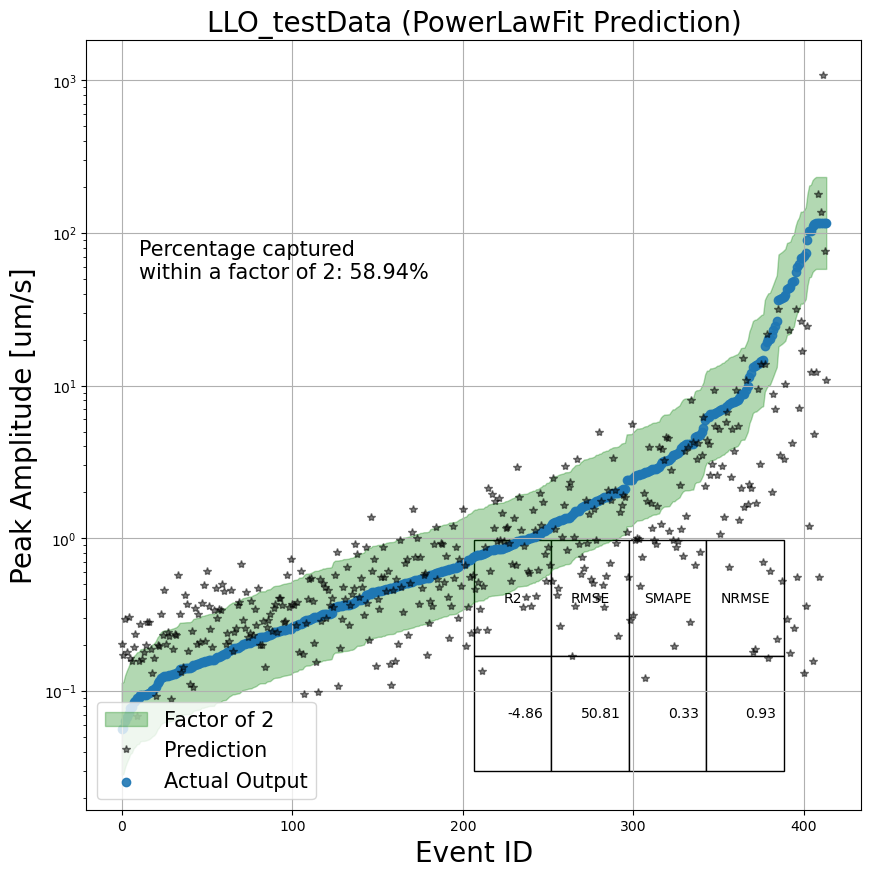

     R2   RMSE  SMAPE  NRMSE
0 -4.86  50.81   0.33   0.93


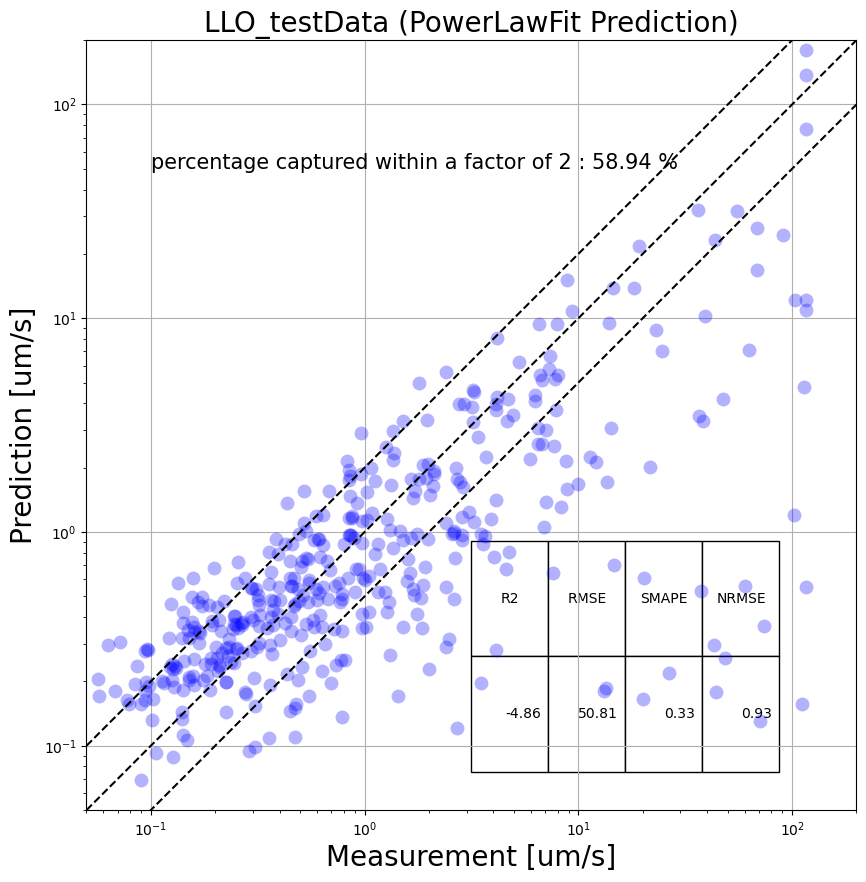

In [12]:
# make predictions on test Data using PowerLaw-Fit
XDATA  = X_test
YDATA  = Y_test 
lat,lon,mag,depth,dist = undoReScaleParams(XDATA.nlat,XDATA.nlon,XDATA.nmag,XDATA.ndepth,XDATA.ndist)

Y_meas = np.array(10**(YDATA-3))

Y_pred,Y_pred_std = powerLawFit(ifo_name,lat,lon,mag,depth)



plot_prediction(Y_meas,Y_pred,Y_pred_std,
                save_fig_and_metrics=1,
                fig_name='{}_testData_PowerLawFit.png'.format(ifo),
                fig_title='{}_testData (PowerLawFit Prediction)'.format(ifo),
                Fac=Fac,
                plot_uncertainity=0,
                save_location=result_folder
                )

scatter_plot_prediction(Y_meas,Y_pred,Y_pred_std,
                save_fig_and_metrics=1,
                fig_name='{}_testData_PowerLawFit_scatter.png'.format(ifo),
                fig_title='{}_testData (PowerLawFit Prediction)'.format(ifo),
                Fac=Fac,
                plot_uncertainity=0,
                save_location=result_folder
                )


In [13]:
# make predictions on random single events

lat = 31
lon = 128
mag = 6.0
depth = 5
ifo_name = ifo

model_name = "gpr_model_"+ifo_name+".dump"
models_path = result_folder
model_fullname = os.path.join(models_path,model_name)

load_model=1
model=[]
Y_pred,Y_pred_std,model = gprPredict(load_model,model_fullname,model,ifo_name,lat,lon,mag,depth)
Ypred_powerLawFit,Ypred_powerLawFit_std = powerLawFit(ifo_name,lat,lon,mag,depth)

[Y_pred,Ypred_powerLawFit]




[array([0.62764249]), array([0.64602836])]